Metabolic EP
=====

Load julia module
-----

In [1]:
# eventually, install repository with import Pkg; Pkg.clone("https://github.com/anna-pa-m/Metabolic-EP/","MetabolicEP.jl")
#import Pkg; Pkg.clone("https://github.com/anna-pa-m/Metabolic-EP/","MetabolicEP.jl")
#using MetabolicEP
include("src/MetabolicEP.jl")

Main.MetabolicEP

Load test metabolic model
------

In [2]:
#met=MetabolicEP.ReadMatrix(Pkg.Dir.path() * "/MetabolicEP/test/ecoli_core_model.mat");
met=MetabolicEP.ReadMatrix("test/ecoli_core_model.mat");
S,b,lb,ub,rxns = MetabolicEP.preprocess(met.S,met.b,met.lb,met.ub,met.rxns);

8 blocked fluxes
EX_fru(e)is fixed to 0.0
EX_fum(e)is fixed to 0.0
EX_gln_L(e)is fixed to 0.0
EX_mal_L(e)is fixed to 0.0
FRUpts2is fixed to 0.0
FUMt2_2is fixed to 0.0
GLNabcis fixed to 0.0
MALt2_2is fixed to 0.0


Run EP
-----

In [3]:
# Finite β
r = MetabolicEP.metabolicEP(S,b,lb,ub,beta=1e9);

Analyzing a 72 × 87 stoichiometric matrix.
Converging with β=1.0e9 maxth=1.0e-6 maxiter=2000:
it = 337 ɛav = 9.83e-07 ɛvar = 8.19e-09 ɛμ = 3.81e-06 ɛs = 6.18e-08                                 .20e-04                 06 ɛvar = 5.42e-08 ɛμ = 1.81e-05 ɛs = 2.46e-07                 


In [10]:
# Beta = Inf 
r0 = MetabolicEP.metabolicEP(S,b,lb,ub,beta=Inf);
display(r0.av)

Analyzing a 72 × 87 stoichiometric matrix.
Converging with β=Inf maxth=1.0e-6 maxiter=2000:
it = 330 ɛav = 9.87e-07 ɛvar = 1.45e-08 ɛμ = 3.75e-06 ɛs = 5.77e-08                 .90e-08 ɛμ = 5.99e-06 ɛs = 8.62e-08                 


87-element Array{Float64,1}:
  -2.0147574846751506  
  -1.0536044384475747  
  -1.4818363117174298  
   9.000224621684227   
   9.000224621684227   
  -1.4818363117174298  
  10.903456060346638   
   3.777645362959752   
  -0.5612386908198675  
  -0.9611174586417848  
  16.45916595899282    
  48.46607868553447    
   0.041818653428592936
   ⋮                   
  -1.0505541656771433  
   4.671092700465814   
  -2.3805739531432577  
  10.949620368638445   
  11.654361158103029   
 503.5929839631648     
  -3.777645362959752   
   2.3430581661371233  
  15.8923786274439     
   2.3430581661371233  
   2.328029927757091   
   7.1978377255624295  

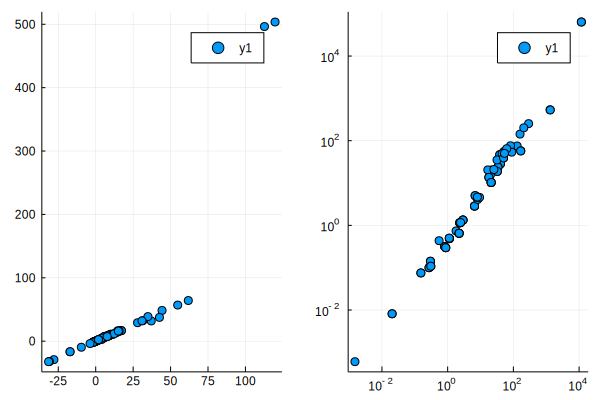

In [26]:
# Compare to naive Hit-and-Run
include("src/HitAndRun.jl")

samples = HitAndRun.sample(S,b,lb,ub);
using Plots, Statistics
sam_mean = mean(samples, dims=1)
sam_var = var(samples, dims=1)
p1 = Plots.scatter(sam_mean', r0.av)
p2 = Plots.scatter(sam_var', r0.va ,xaxis=:log, yaxis=:log)
Plots.plot(p1,p2)

Plot marginals
-----
    
Marginals are truncated Normal



$$P(\nu_i)\propto \mathbb{I}[l_i\leq\nu_i\leq u_i]e^{-\frac{(\nu_i-\mu_i)^2}{2s_i}}$$

In [ ]:
#if you miss these packages, use Pkg.add("Distributions); Pkg.add("Gadfly")
using Distributions, Gadfly

function plotmarg(i)
    μ,s,l,u=r0.μ[i],r0.σ[i],lb[i],ub[i]
    d=Normal(μ,√s);
    D=Truncated(d,l,u);
    #choose bounds to have a sensible plotting range
    m=max(pdf(d,l),pdf(d,u),(l<μ<u) ? 1/sqrt(2pi*s) : 0);
    v=sqrt(-2*s*log(sqrt(2pi*s)*1e-5m));
    l1,l2=max(l,μ-v),min(u,μ+v);
    return Gadfly.plot(x->pdf(D,x),l1,l2,Guide.YLabel(""),Guide.XLabel(met.rxns[i]))
end

#build plot grid with R rows and 5 columns (up to R=19)
R=17
P=[plotmarg(i) for i=1:5R]
Gadfly.set_default_plot_size(30cm,R*5cm)
Gadfly.gridstack(reshape(P,R,5))